In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [70]:
def make_submission(X_test, net, fname="my_submission1.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [130]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if((y == Y_test[i]).any):
            acc += 1.0
    return acc / Y_test.shape[0]

In [59]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_valid = test_data['data']

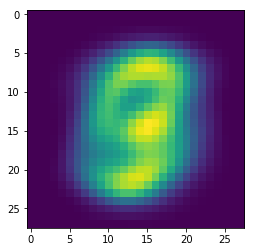

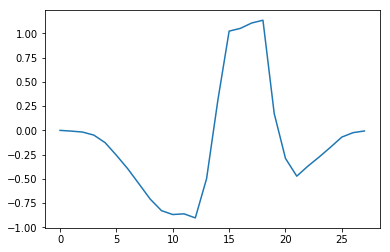

In [60]:
# Подготовка датасета
X_train = X_train.astype('float')
Xm = np.mean(X_train, axis=0)
Xs = np.std(X_train, axis=0)
X_train=(X_train - Xm) / (Xs + 0.01)
X_valid=(X_valid-Xm)/(Xs+0.01)
plt.imshow(Xm.reshape((28, 28)))
plt.figure()
plt.plot(X_train[0].reshape((28, 28))[14])
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train_oh, test_size=0.33, stratify=Y_train_oh)


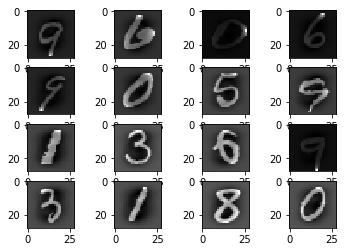

In [61]:
# то что предстоит обучать
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X_train[np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [62]:
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [65]:
class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz
  # TODO
class Softmax:
    
    def forward(self, x):
        self.x=x
        self.exps=np.exp(x-np.max(x))
        self.sm=self.exps/np.sum(self.exps)
        return self.sm

    def backward(self, dz,lr=0.001):
        dz1=np.matmul((self.sm*(np.eye(self.x.shape[0])-self.sm).T),dz)

        return dz1
  # TODO
class CrossEntropy:
    def forward(self, y_true, y_hat):
        self.y_true=y_true
        self.y_hat=y_hat
        result =-np.matmul(y_true,np.log(y_hat+1e-10))
        assert math.isnan(result)== False,(y_hat,result,'crossEntropy forward')
        return result
# 
    def backward(self, dz, lr=0.001):
        return -dz*(self.y_true/(self.y_hat+1e-10))

In [66]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2 / in_size)
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [111]:
class MnistNet:
    
    def __init__(self,p=0.1, rlambda=0.01):
        self.d1 = Dense(784, 100, rlambda)
        self.m1 = ReLU()
        self.d2 = Dense(100, 40, rlambda)
        self.m2 = ReLU()
        self.drop=Dropout(p)
        self.d3 = Dense(40, 20, rlambda)
        self.m3 = ReLU()
        self.d4 = Dense(20, 10, rlambda)

        self.s = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.m1.forward(net)
        net = self.d2.forward(net)
        net = self.m2.forward(net)
        net = self.d3.forward(net)
        net = self.m3.forward(net)
        net = self.drop.forward(net)
        net = self.d4.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d4.backward(dz, lr)
        dz = self.drop.backward(dz,lr)
        dz = self.m3.backward(dz, lr)
        dz = self.d3.backward(dz, lr)
        dz = self.m2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

In [102]:
import tqdm

In [114]:
# Здесь процедура обучения

net = MnistNet(rlambda=0.001)
# net=net1
loss = CrossEntropy()
lr = .005
L_train = []
L_test = []
for iter in tqdm.tqdm_notebook(range(30)):
    L_acc = 0.
    sh = list(range(X_train.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    #обучение
    net.drop.set_train(True)
    for i in range(X_train.shape[0]):
        x = X_train[sh[i]]
        y = Y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1)
        dz = net.backward(dz,lr)
    L_acc /= (Y_train.shape[0])
    L_train.append(L_acc)
    L_e_acc = 0.
    net.drop.set_train(False)
    тестирование
    for i in range(X_test.shape[0]):
        x = X_test[i]
        y = Y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_e_acc += L
        if(math.isnan(L)):
            print(y_h,y,L_e_acc)

    L_e_acc /= Y_test.shape[0]
    L_test.append(L_e_acc)
    lr*=0.98
    if(iter%5==0):
        print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))


0 iter loss. Train : 0.3333594588476539 . Test : 0.2137052758401808
5 iter loss. Train : 0.08914792093446448 . Test : 0.1438720061239951
10 iter loss. Train : 0.048899743350146754 . Test : 0.13581876512566013
15 iter loss. Train : 0.049261172859173134 . Test : 0.14596896287155192
20 iter loss. Train : 0.030513466992267035 . Test : 0.10502970124000059
25 iter loss. Train : 0.028264551194259933 . Test : 0.09831861117161542


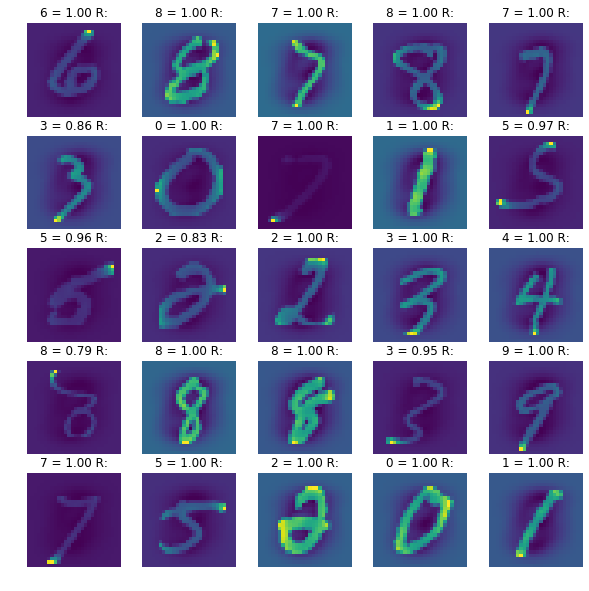

In [124]:
# Проверим всё это дело наяву
plt.figure(figsize=(10,10))

sh = list(range(X_valid.shape[0]))
np.random.shuffle(sh)

n = 5
for i in range(n*n):
    ax = plt.subplot(n, n, i+1)

    j = sh[i]
    #R = np.argmax(Y_test[j])
    P = net.forward(X_valid[j])
    Rp = np.argmax(P)

    ax.set_title('%s = %.2f R:' % (Rp, P[Rp]))
    ax.set_axis_off()
    plt.imshow(X_valid[j].reshape((28, 28)))

In [13]:
import math

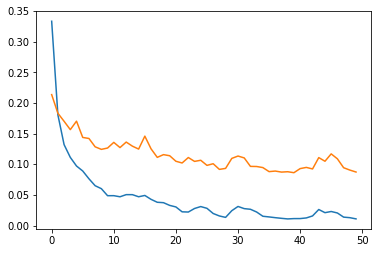

In [118]:
# Подведем итоги нашего обучения
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')

In [125]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_valid, net)